In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import chi2

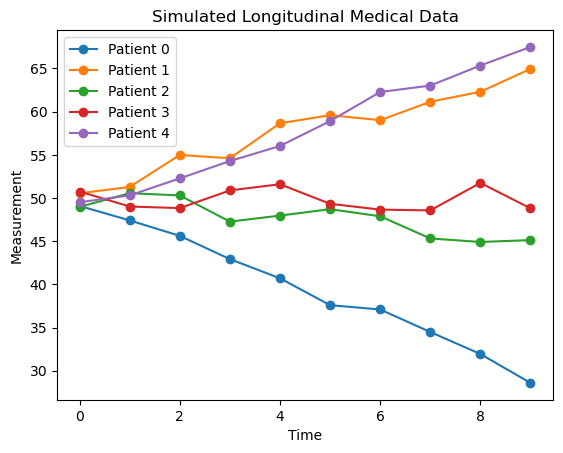

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_longitudinal_data(num_patients, effect_size, sigma_individual, sigma_noise):
    """
    Simuliert einen longitudinalen Datensatz basierend auf einem gemischten Modell.
    
    :param num_patients: Anzahl der Patienten
    :param num_measurements: Anzahl der Messungen pro Patient
    :param effect_size: Größe des Effekts der Behandlung
    :param sigma_individual: Standardabweichung der zufälligen Effekte
    :param sigma_noise: Standardabweichung des Messrauschens
    :return: DataFrame mit simulierten Daten
    """
    num_measurements = np.random.choice([4,5,6,7,8,9,10])
    # Patienten-ID und Zeitpunkte
    patient_id = np.repeat(np.arange(num_patients), num_measurements)
    time = np.tile(np.arange(num_measurements), num_patients)

    # Zufällige Effekte für jeden Patienten
    random_intercepts = np.random.normal(0, sigma_individual, num_patients)
    random_slopes = np.random.normal(0, sigma_individual, num_patients)
    
    # Behandlungsgruppe
    treatment = np.random.choice([0, 1], num_patients)  # 0 = Kontrollgruppe, 1 = Behandlungsgruppe
    treatment_effect = treatment.repeat(num_measurements) * effect_size * time
    
    # Simuliere Messwerte
    measurement_error = np.random.normal(0, sigma_noise, num_patients * num_measurements)
    # Korrekte Berechnung von 'measurements'
    random_slopes_repeated = random_slopes.repeat(num_measurements)  # Stellt sicher, dass 'random_slopes' die gleiche Länge hat wie 'time'
    measurements = 50 + random_intercepts.repeat(num_measurements) + (random_slopes_repeated * time) + treatment_effect + measurement_error
    
    # Erstelle DataFrame
    data = pd.DataFrame({
        'Patient_ID': patient_id,
        'Time': time,
        'Treatment': treatment.repeat(num_measurements),
        'Measurement': measurements
    })
    
    return data

# Parameter
num_patients = 100
num_measurements = 10
effect_size = 0.5  # Effektgröße der Behandlung über Zeit
sigma_individual = 2  # Standardabweichung der zufälligen Effekte
sigma_noise = 1  # Standardabweichung des Messrauschens

# Daten simulieren
data = simulate_longitudinal_data(num_patients, num_measurements, effect_size, sigma_individual, sigma_noise)

# Plot der Daten für einige Patienten
for pid in np.unique(data['Patient_ID'])[:5]:
    patient_data = data[data['Patient_ID'] == pid]
    plt.plot(patient_data['Time'], patient_data['Measurement'], marker='o', label=f'Patient {pid}')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Simulated Longitudinal Medical Data')
plt.legend()
plt.show()

In [16]:
# SIMULATING THE DATA 

# PARAMETERS
num_patients = 200 # number of patients
patient_affected_prob = 0.6 # probability if patient is affected
mean_test_score = 40 # fixed intercept

noise_var = 0.1  
var_time_effect = 1.0
var_intercept = 1.0  # intercept steht für Ausgangsniveau
var_slope = 0.1 # slope steht für effektstärke / steigung

b_1 = -4.0 # effect of affected family
b_2 = 0.0 # effect of sex 
b_3 = 0.2 # effect of age

# calculating data for num_patients patients 
def simulate_data(num_patients):
    # Generate data
    data = []
    data_we = []

    # simuliere einen Datensatz eines Krankheitsverlauf mit infizierten und gesunden Patienten def simulate_dataset(num_patients):
    for patient_id in range(num_patients):
        # Randomly determine if family is affected
        patient_affected = np.random.choice([0, 1], p=[1-patient_affected_prob, patient_affected_prob])
    
        # Randomly determine sex
        sex = np.random.choice([0, 1], p=[1-0.5,0.5]) # 50/50 male or women 

        # Randomly determine age
        age = np.random.normal(40,10) # mean_age=40, age_std=10
    
        # Randomly generate time points
        num_time_points = np.random.choice([4,5,6,7,8,9,10])
        time_points = np.sort(np.random.uniform(0, 10, num_time_points))
    
        # Generate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, var_slope)
        time_effects = np.random.normal(0.0, np.sqrt(var_time_effect))
    
        for j,t in enumerate(time_points):
            # Generate noise
            noise = np.random.normal(0.0, np.sqrt(noise_var))
        
            # Simulate test score
            test_score = mean_test_score + random_intercept + b_1 * patient_affected + b_2 * sex + b_3 * age +  time_effects * t + random_slope + noise

            data.append([patient_id, t, patient_affected, sex, age, test_score])
    return pd.DataFrame(data, columns=['PatientID', 'Time', 'Affected', 'Sex', 'Age', 'Score'])


In [18]:
lrt_results = []
for _ in range(100):
    # Beispielparameter
    data = simulate_data(200)

    # Modell anpassen
    full_model = smf.mixedlm("Score ~ Affected + Sex + Age + Time", data, groups=data["PatientID"], re_formula="~Time")
    full_fit = full_model.fit()

    # Reduziertes Modell ohne Effekt von 'Sex'
    reduced_model = smf.mixedlm("Score ~ Affected + Age + Time", data, groups=data["PatientID"], re_formula="~Time")
    reduced_fit = reduced_model.fit()

    # Manuelle Berechnung des Likelihood Ratio Tests
    lr_statistic = 2 * (full_fit.llf - reduced_fit.llf)
    df_diff = (full_fit.df_model - reduced_fit.df_model)  # Freiheitsgrade basierend auf Modellparametern

    # p-Wert aus Chi-Quadrat-Verteilung
    p_value = 1 - stats.chi2.cdf(lr_statistic, df_diff)

    # LRT durchführen
    lrt_results.append(p_value)


AttributeError: 'MixedLMResults' object has no attribute 'df_model'

In [ ]:
def calculate_likelihood_with_decompositions(df, random_effects_keys, fixed_effects_keys):
    N = len(df)
    n_rand_eff = len(random_effects_keys) + 1
    n_fixed_eff = len(fixed_effects_keys) + 1

    # Ensure that the diagonal covariance matrix has only positive values
    Delta = torch.diag(softplus(D_param))
    det_delta = torch.det(Delta)  

    Z_list = calculate_Zlist(df, random_effects_keys)
    X_list = calculate_Xlist(df, fixed_effects_keys)
    Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list]
    X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list]
    Q_list = [QR_decomposition(Z_i)[0] for Z_i in Z_tilde_list]
    R11_list = [QR_decomposition(Z_i)[1][:n_rand_eff, :n_rand_eff] for Z_i in Z_tilde_list]
    R00_list = [Q_list[i].T @ X_tilde_list[i] for i in range(Z_tilde_list.shape[0])]
    sigma2 = 1
    c_1 = 1
    c_0 = 1
    R_00 = 1
    beta = 1
    likelihood = - N/2 *torch.log(2* torch.pi * sigma2) + ((c_1 + c_0 - R_00 * beta) / (-2* sigma2))
    likelihood += torch.log([det_delta / torch.det(R11_i) for R11_i in R11_list]).sum()
    return likelihood

In [ ]:
def calculate_chol_likelihood(df, fixed_effects, random_effects):
    n_fixed_eff = len(fixed_effects) + 1
    n_rand_eff = len(random_effects) + 1
    N = len(df)

    D_param = torch.randn(n_rand_eff, requires_grad=True)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list = calculate_Xlist(df, fixed_effects)
    # Random effects design matrix (Datenmatrix) for each patient
    Z_list = calculate_Zlist(df, random_effects)
    # Response variable: Test scores
    y = torch.from_numpy(np.array(df['test_score'])).to(torch.float32)

    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e = torch.cat([torch.cat((y[get_ind(pat, df)], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in df['patient_id'].unique()])

    # Ensure that the diagonal covariance matrix has only positive values
    Delta = torch.diag(torch.nn.functional.softplus(D_param))
    # Calculate the Cholesky decomposition of Delta
    chol_Delta = torch.linalg.cholesky(Delta)
    det_Delta = torch.prod(torch.diag(chol_Delta))**2  # Determinant via Cholesky

    # Define Z_tilde and compute Cholesky decompositions for each Z_tilde matrix
    Z_tilde_list = [torch.cat((Z_i, chol_Delta)) for Z_i in Z_list]
    X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list]
    # Matrix X_e (eq. 2.11 p. 65)
    X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)

    # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
    X_e_T_X_e = X_e.t() @ X_e
    chol_X_e_T_X_e = torch.linalg.cholesky(X_e_T_X_e)
    inv_X_e_T_X_e = torch.cholesky_inverse(chol_X_e_T_X_e)
    pred = inv_X_e_T_X_e @ X_e.t() @ y_e

    # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
    residuals = y_e - X_e @ pred
    pred_sigma = torch.sum(residuals ** 2) / N

    # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
    likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
    likelihood += torch.sum(torch.log(torch.diag(chol_X_e_T_X_e))) - torch.sum(torch.log(torch.diag(chol_Delta)))

    return -likelihood

In [ ]:
def run_simulation(num_simulations): 
    lrt_results = []
    params_full = torch.randn(len(random_effects_keys) + 1, requires_grad=True) #np.array([...]) Startwerte
    params_reduced = torch.randn(len(random_effects_keys) + 1, requires_grad=True) #np.array([...]) Startwert
    for _ in range(num_simulations):
        data = pd.DataFrame(simulate_data(200), columns=['patient_id', 'years_after_treatment', 'familiy_affected', 'sex', 'age', 'test_score'])
        # Modelle anpassen
        # Hier müssen Sie die Parameterinitialisierung und -optimierung hinzufügen
        result_full = minimize(calculate_likelihood_full, params_full, method='bfgs', max_iter=6)
        result_reduced = minimize(calculate_likelihood_reduced, params_reduced, method='bfgs', max_iter=6)

        # Likelihoods berechnen
        log_likelihood_full = -result_full.fun
        log_likelihood_reduced = -result_reduced.fun
        # LRT durchführen
        df_diff = len(params_full) - len(params_reduced)
        lrt_stat = likelihood_ratio(log_likelihood_full, log_likelihood_reduced, 1)
        lrt_results.append(lrt_stat)
    return lrt_results